In [ ]:

import torch
import loralib as lora
from happytransformer import HappyTextToText
from transformers import T5Tokenizer

model_name = "t5-small"
happy_tt = HappyTextToText(model_name)
tokenizer = happy_tt.tokenizer

# Replace the query and value projection layers in the T5 model with lora.Linear
r = 16  # Rank for the low-rank adaptation matrices
for block in happy_tt.model.encoder.block:
    attn = block.layer[0].SelfAttention
    attn.q = lora.Linear(attn.q.in_features, attn.q.out_features, r=r)
    attn.v = lora.Linear(attn.v.in_features, attn.v.out_features, r=r)

for block in happy_tt.model.decoder.block:
    attn = block.layer[0].SelfAttention
    attn.q = lora.Linear(attn.q.in_features, attn.q.out_features, r=r)
    attn.v = lora.Linear(attn.v.in_features, attn.v.out_features, r=r)


lora.mark_only_lora_as_trainable(happy_tt.model)

inputs = [
    {
        "input": "grammar: I has poor grammars",
        "target": "I have poor grammar"
    },
    {
        "input": "grammar: I wants too plays",
        "target": "I want to play"
    }
]

from happytransformer import HappyTextToText, TTTrainArgs

happy_tt = HappyTextToText()
args = TTTrainArgs(num_train_epochs=1) 

happy_tt.train(inputs, args=args)

# Save the LoRA checkpoint
torch.save(lora.lora_state_dict(happy_tt.model), "t5_lora_checkpoint.pt")

# Load the pretrained checkpoint first
happy_tt.load_model(model_name)
happy_tt.model.load_state_dict(torch.load("t5_pretrained_checkpoint.pt"), strict=False)

# Then load the LoRA checkpoint
happy_tt.model.load_state_dict(torch.load("t5_lora_checkpoint.pt"), strict=False)


In [ ]:
"""

Requirements

1. Perform Named Entity Recognition (NER) to extract entities such as PERSON, ORG, and GPE from sentences using libraries like Stanford NER or spaCy.
2. Perform dependency parsing using libraries like Stanford Parser or spaCy to identify actions, modifiers, and relationships between entities.
3. Extract root verbs as main actions and identify modifiers or adverbial phrases that modify actions or entities.
4. Use part-of-speech (POS) tagging with libraries like NLTK or spaCy to extract adjectives and other descriptive words that modify entities.
5. Incorporate extracted entities with appropriate labels in the knowledge graph, connecting them with edges to relevant actions and modifiers.
6. Add extracted adjectives and descriptive words as nodes in the knowledge graph, connecting them with edges to relevant entities.
7. Label the root verbs as main actions in the knowledge graph.
8. Use chunking or shallow parsing with NLTK to identify and group relevant nouns, pronouns, and related words not captured by NER (such as compound words that should be treated as a singular entity, dropping the use of their individual terms for graphing).
9. Add extracted nouns, pronouns, and related words as nodes in the knowledge graph, connecting them with edges to relevant entities, actions, and modifiers.
10. Implement coreference resolution to identify and resolve pronouns and referring expressions, maintaining correct relationships between entities in the knowledge graph.
11. Ensure the knowledge graph accurately represents relationships between entities, including type_of relationships and location-based relationships (e.g., "at", "to", "in", "for", "from", "where").
12. Identify other nouns that are not classified as PERSON, ORG, or GPE and label them as 'THING' in the knowledge graph. Connects 'THING' nodes with appropriate edge to relevant ACTION, MODIFIER, and entities.
13. Resolve coreferences in the text before processing it for the knowledge graph.
14. Display the knowledge graph with nodes representing entities, actions, modifiers, and edges representing their relationships.
15. Save the knowledge graph as a JSON file for further analysis or visualization.
16. Treat conjunctions such as "and" as ADP (adpositions) and use them as "CONNECTS" edges in the graph. This will ensure that relationships between entities, actions, and modifiers are accurately captured even when conjunctions are present in the text. 
17. Handle conjunctions and propagate the subject information in case of conjunctions.
18. Track compound nouns and skip the nodes that are part of a compound noun when adding nodes and edges. 
19. Coreference Resolution using Stanford CoreNLP server: The implementation resolves coreferences in the text before processing it for the knowledge graph. This is done by making a request to a Stanford CoreNLP server instance running on a specified IP address and port.
20. Merging Compound Nouns: The implementation includes a function `merge_compound_nouns` that processes the spaCy document and merges compound nouns into a single token. This helps in accurately capturing compound nouns as single nodes in the knowledge graph.
21. Handling Conjunctions: The implementation includes logic to handle conjunctions and propagate subject information in case of conjunctive verbs. This ensures that relationships between entities, actions, and modifiers are accurately captured even when conjunctions are present in the text.
22. Removing ADP Nodes: The implementation removes nodes with the label 'ADP' from the graph, directly connecting the nodes that would otherwise be connected by adpositions.
23. Removing Edges with Label 'ACTION': The implementation removes edges with a label of 'ACTION' from the graph, ensuring that only relevant connections are represented.
24. Filter subjects and objects based on the valid node types (PERSON, ORG, GPE, or THING). Check if both the subject and object appear in the same sentence, if so, add a 'CONNECTS' edge between them.

These additional features improve the accuracy and comprehensibility of the generated knowledge graph.

Goal of standardized relationships:

	Subject - (NER entity) - CONNECTS - ACTION and/or MODIFIER (or vice-versa) - CONNECTS - Object (NER entity)

The only nodes should be the following types

PERSON, ORG, GPE, THING, ACTION, MODIFIER

Basic logic should be
Check if entity?  If so, what type?
PERSON, ORG, GPE?

If not entity, do POS tagging
    If Noun (or ('attr', 'dobj', 'pobj', 'prep', 'agent', 'compound', 'amod', 'advmod', 'nsubj', 'nsubjpass')) and not entity, node type is THING.
    If a VERB, then node type is ACTION
    If an ADJECTIVE, node type is MODIFIER
    POS tags of ADP (in, at, to, for, are) are edges of CONNECTS and relate
        PERSON, ORG, GPE or THING
        with VERB or ADJECTIVE and other 
        PERSON, ORG, GPE or THING

For nodes what should be plotted should be the nominal text of the entity (i.e. 'John', 'Google', 'California') (not the node Type).

The only edges should be of type "CONNECTS", and what is plotted is "CONNECTS". 
example CONNECT words of these types: in, at, to, for, are
Directly connect the nodes that would otherwise be connected 
by ADPs.
"""

In [2]:
sentences = ["John works at Google in California.",
             "Mary lives in Paris and works for Microsoft.",
             "The Eiffel Tower is located in France."]
print(sentences)

['John works at Google in California.', 'Mary lives in Paris and works for Microsoft.', 'The Eiffel Tower is located in France.']


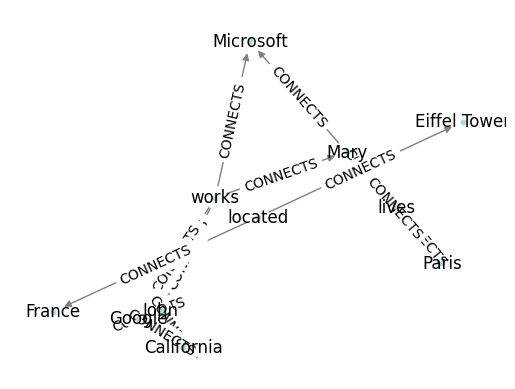

In [182]:
#v1
#Implementation:

import spacy
import networkx as nx
import json
import requests
import matplotlib.pyplot as plt

def find_subject(verb):
    for child in verb.children:
        if child.dep_ in ('nsubj', 'nsubjpass'):
            return child
    return None

# Function to resolve coreferences using CoreNLP server
def coref_resolution(text):
    corenlp_url = 'http://192.168.3.100:9000'
    params = {
        'properties': json.dumps({
            'annotators': 'coref',
            'outputFormat': 'json'
        })
    }
    response = requests.post(corenlp_url, data=text.encode('utf-8'), params=params)

    if response.status_code == 200:
        corenlp_output = response.json()
        corefs = corenlp_output['corefs']
        for coref_chain in corefs.values():
            if len(coref_chain) == 1:
                continue
            main_ref = coref_chain[0]['text']
            for ref in coref_chain[1:]:
                start = ref['startIndex'] - 1
                end = ref['endIndex'] - 1
                #text = text[:start] + main_ref + text[end:]
                text = text[:start] + main_ref + " " + text[end:]
        return text
    else:
        return None
    
def add_edges(doc, G):
    for chunk in doc.noun_chunks:
        if not any(tok.ent_type_ for tok in chunk):
            G.add_node(chunk.text, label="THING")

    for token in doc:
        if token.dep_ in (
        'attr', 'dobj', 'pobj', 'prep', 'agent', 'compound', 'amod', 'advmod', 'nsubj', 'nsubjpass', 'conj'):

            if token.head.ent_type_:
                node_label = token.head.ent_type_
            elif token.head.pos_ == 'VERB':
                node_label = 'ACTION'
            else:
                node_label = token.head.pos_

            if token.ent_type_:
                label = token.ent_type_
            elif token.pos_ == 'VERB':
                label = 'ACTION'
            else:
                label = token.pos_

            if label == 'FAC':
                label = 'THING'

            if token.dep_ == 'compound':
                compound_token = token.head.text + ' ' + token.text
                G.add_node(compound_token, label=node_label)
                G.add_edge(compound_token, token.head.text, label="CONNECTS")
            else:
                G.add_node(token.head.text, label=node_label)
                G.add_node(token.text, label=label)

                if token.dep_ in ('pobj', 'prep', 'nsubj', 'nsubjpass'):
                    edge_label = 'CONNECTS'
                else:
                    edge_label = label

                if token.head.pos_ == "ADP":
                    for child in token.head.children:
                        if child != token:
                            G.add_edge(token.text, child.text, label="CONNECTS")
                elif token.pos_ == "ADP":
                    for child in token.children:
                        G.add_edge(token.head.text, child.text, label="CONNECTS")
                else:
                    G.add_edge(token.head.text, token.text, label=edge_label)

            # Propagate subject information in case of conjunctions
            if token.dep_ == 'conj':
                if token.head.pos_ == "VERB" and token.pos_ == "VERB":
                    # Identify and store the subject of the first verb
                    subject = None
                    for child in token.head.children:
                        if child.dep_ == 'nsubj':
                            subject = child.text
                    # Create a new sentence by attaching the subject to the second verb
                    new_sentence = subject + " " + token.text
                    # Add children of the second verb to the new sentence
                    for child in token.children:
                        if child.dep_ not in ('conj', 'punct'):
                            new_sentence += " " + child.text
                    # Process the new sentence using spaCy
                    new_doc = nlp(new_sentence)
                    # Add edges for the new sentence
                    add_edges(new_doc, G)
                else:
                    subject = None
                    for child in token.head.children:
                        if child.dep_ == 'nsubj':
                            subject = child.text
                    if subject:
                        for child in token.children:
                            if not child.dep_ == 'conj':
                                if child.dep_ in ('dobj', 'pobj', 'attr', 'agent', 'prep'):
                                    G.add_edge(subject, child.text, label="CONNECTS")
                                if child.dep_ == "nsubj" and token.head.pos_ == "VERB":
                                    G.add_edge(subject, token.text, label="CONNECTS")


# Sample sentences
sentences = ["John works at Google in California.",
             "Mary lives in Paris and works for Microsoft.",
             "The Eiffel Tower is located in France."]



# Initialize knowledge graph
G = nx.DiGraph()

# Load the spaCy model
nlp = spacy.load("en_core_web_trf")

# Process sentences with spaCy
docs = [nlp(sentence) for sentence in sentences]

# Resolve coreferences using Stanford CoreNLP server
resolved_sentences = [coref_resolution(doc.text) for doc in docs]

def merge_compound_nouns(doc):
    with doc.retokenize() as retokenizer:
        for token in doc:
            if token.dep_ == 'compound':
                compound_token = token.head.text + ' ' + token.text
                retokenizer.merge(doc[token.i: token.head.i + 1], attrs={"ORTH": compound_token})
    return doc

# Process resolved sentences with spaCy
resolved_docs = [merge_compound_nouns(nlp(sentence)) for sentence in resolved_sentences]

# Add nodes and edges to the graph
for doc in resolved_docs:
    add_edges(doc, G)
    
adp_nodes = [node for node, data in G.nodes(data=True) if data['label'] == 'ADP']
for adp_node in adp_nodes:
    G.remove_node(adp_node)

# Remove edges with a label of 'ACTION'
edges_to_remove = [(source, target) for source, target, data in G.edges(data=True) if data['label'] == 'ACTION']
G.remove_edges_from(edges_to_remove)

def add_relationships(G, sentences):
    valid_node_types = {'PERSON', 'ORG', 'GPE', 'THING'}

    for sentence in sentences:
        doc = nlp(sentence)
        subjects = [tok for tok in doc if tok.dep_ in ('nsubj', 'nsubjpass') and tok.text in G.nodes and G.nodes[tok.text]['label'] in valid_node_types]
        objects = [tok for tok in doc if tok.dep_ in ('dobj', 'attr', 'pobj', 'prep', 'agent') and tok.text in G.nodes and G.nodes[tok.text]['label'] in valid_node_types]

        for subject in subjects:
            for obj in objects:
                if subject.text in sentence and obj.text in sentence and not G.has_edge(subject.text, obj.text):
                    G.add_edge(subject.text, obj.text, label="CONNECTS")

add_relationships(G, sentences)

# Draw the knowledge graph
pos = nx.spring_layout(G)
node_labels = {node: node for node, data in G.nodes(data=True)}
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=10)
nx.draw_networkx_edges(G, pos, edge_color='gray')
nx.draw_networkx_labels(G, pos, labels=node_labels)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.axis('off')
plt.show()

# Save the knowledge graph as a JSON file
graph_data = {
    'nodes': [{'id': node, 'label': data.get('label', 'unknown')} for node, data in G.nodes(data=True)],
    'links': [{'source': source, 'target': target, 'label': data.get('label', 'unknown')} for source, target, data in G.edges(data=True)]
}
with open('knowledge_graph.json', 'w') as f:
    json.dump(graph_data, f, indent=4)

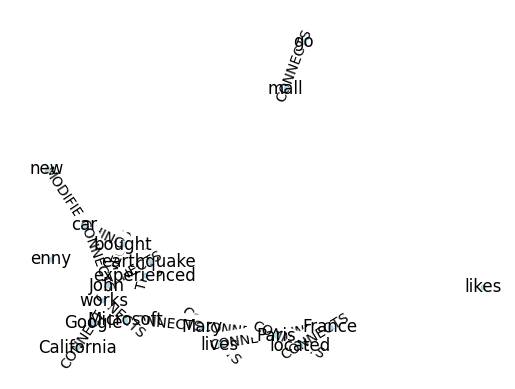

In [188]:
#v4.5
import spacy
import networkx as nx
import json
import requests
import matplotlib.pyplot as plt


class KnowledgeGraph:

    def __init__(self):
        self.G = nx.DiGraph()
        self.nlp = spacy.load("en_core_web_trf")

    def save_nlp_to_pickle(self, resolved_docs, filename):
        with open(filename, 'wb') as f:
            pickle.dump(resolved_docs, f)

    def load_nlp_from_pickle(self, filename):
        with open(filename, 'rb') as f:
            resolved_docs = pickle.load(f)
        return resolved_docs        
        
    def process_sentences(self, sentences):
        self.sentences = sentences
        docs = [self.nlp(sentence) for sentence in sentences]
        resolved_sentences = [self.coref_resolution(doc.text) for doc in docs]
        resolved_docs = [self.merge_compound_nouns(self.nlp(sentence)) for sentence in resolved_sentences]

        for doc in resolved_docs:
            self.add_edges(doc)

        self.cleanup_graph()
        self.add_relationships(sentences)
        self.post_process_graph()

    def find_subject(self, verb):
        for child in verb.children:
            if child.dep_ in ('nsubj', 'nsubjpass'):
                return child
        return None

    def is_redundant_verb(self, token):
        if token.pos_ == "VERB":
            prominent_verbs = [child for child in token.children if child.pos_ == "VERB" and child.dep_ in ('xcomp', 'ccomp')]
            if prominent_verbs:
                return True
        return False

    def coref_resolution(self, text):
        # Replace IP address and port with your Stanford CoreNLP server instance
        corenlp_url = 'http://192.168.3.100:9000'
        params = {
            'properties': json.dumps({
                'annotators': 'coref',
                'outputFormat': 'json'
            })
        }
        response = requests.post(corenlp_url, data=text.encode('utf-8'), params=params)

        if response.status_code == 200:
            corenlp_output = response.json()
            corefs = corenlp_output['corefs']
            for coref_chain in corefs.values():
                if len(coref_chain) == 1:
                    continue
                main_ref = coref_chain[0]['text']
                for ref in coref_chain[1:]:
                    if ref['isRepresentativeMention']:
                        main_ref_index = ref['headIndex']
                    else:
                        start = ref['startIndex'] - 1
                        end = ref['endIndex'] - 1
                        text = text[:start] + text[end:]
            return text
        else:
            return None

    def merge_compound_nouns(self, doc):
        with doc.retokenize() as retokenizer:
            for token in doc:
                if token.dep_ == 'compound':
                    compound_token = token.head.text + ' ' + token.text
                    retokenizer.merge(doc[token.i: token.head.i + 1], attrs={"ORTH": compound_token})
        return doc

    def add_edges(self, doc):
        for chunk in doc.noun_chunks:
            if not any(tok.ent_type_ for tok in chunk):
                self.G.add_node(chunk.text, label="THING")

        for token in doc:
            if token.dep_ in (
                    'attr', 'dobj', 'pobj', 'prep', 'agent', 'compound', 'amod', 'advmod', 'nsubj', 'nsubjpass', 'conj'):

                if token.head.ent_type_:
                    node_label = token.head.ent_type_
                elif token.head.pos_ == 'VERB':
                    node_label = 'ACTION'
                else:
                    node_label = token.head.pos_

                if token.ent_type_:
                    label = token.ent_type_
                elif token.pos_ == 'VERB' and not self.is_redundant_verb(token):
                    label = 'ACTION'
                else:
                    label = token.pos_

                if label in {'FAC', 'NOUN'}:
                    label = 'THING'

                if token.pos_ == "ADJ":
                    label = "MODIFIER"

                # Check if the current token is a verb and has a parent verb in the dependency tree
                has_parent_verb = False
                if token.pos_ == 'VERB':
                    for ancestor in token.ancestors:
                        if ancestor.pos_ == 'VERB':
                            has_parent_verb = True
                            break

                # Skip adding the edge if the current token is a verb and has a parent verb
                if has_parent_verb:
                    continue

                if token.dep_ == 'compound':
                    compound_token = token.head.text + ' ' + token.text
                    self.G.add_node(compound_token, label=node_label)
                    self.G.add_edge(compound_token, token.head.text, label="CONNECTS")
                else:
                    self.G.add_node(token.head.text, label=node_label)
                    self.G.add_node(token.text, label=label)

                    if token.dep_ in ('pobj', 'prep', 'nsubj', 'nsubjpass'):
                        edge_label = 'CONNECTS'
                    else:
                        edge_label = label

                    if token.head.pos_ == "ADP":
                        for child in token.head.children:
                            if child != token:
                                self.G.add_edge(child.text, token.text, label="CONNECTS")
                    elif token.pos_ == "ADP":
                        for child in token.children:
                            self.G.add_edge(child.text, token.head.text, label="CONNECTS")
                    else:
                        self.G.add_edge(token.head.text, token.text, label=edge_label)
                if token.pos_ == "ADJ":
                    edge_label = "CONNECTS"
                if token.dep_ == 'conj':
                    if token.head.pos_ == "VERB" and token.pos_ == "VERB":
                        subject = None
                        for child in token.head.children:
                            if child.dep_ == 'nsubj':
                                subject = child.text
                        new_sentence = subject + " " + token.text
                        for child in token.children:
                            if child.dep_ not in ('conj', 'punct'):
                                new_sentence += " " + child.text
                        new_doc = self.nlp(new_sentence)
                        self.add_edges(new_doc)
                    else:
                        subject = None
                        for child in token.head.children:
                            if child.dep_ == 'nsubj':
                                subject = child.text
                        if subject:
                            for child in token.children:
                                if not child.dep_ == 'conj':
                                    if child.dep_ in ('dobj', 'pobj', 'attr', 'agent', 'prep'):
                                        self.G.add_edge(subject, child.text, label="CONNECTS")
                                    if child.dep_ == "nsubj" and token.head.pos_ == "VERB":
                                        self.G.add_edge(subject, token.text, label="CONNECTS")
            elif token.dep_ == 'det':
                continue


    def cleanup_graph(self):
        adp_nodes = [node for node, data in self.G.nodes(data=True) if data['label'] == 'ADP']
        for adp_node in adp_nodes:
            self.G.remove_node(adp_node)

        edges_to_remove = [(source, target) for source, target, data in self.G.edges(data=True) if data['label'] == 'ACTION']
        self.G.remove_edges_from(edges_to_remove)
        
        # Remove redundant nodes
        redundant_nodes = [node for node, data in self.G.nodes(data=True) if data['label'] in {"PRON", "AUX", "SCONJ"}]
        self.G.remove_nodes_from(redundant_nodes)

    def add_relationships(self, sentences):
        valid_node_types = {'PERSON', 'ORG', 'GPE', 'THING'}

        for sentence in sentences:
            doc = self.nlp(sentence)
            subjects = [tok for tok in doc if tok.dep_ in ('nsubj', 'nsubjpass') and tok.text in self.G.nodes and
                        self.G.nodes[tok.text]['label'] in valid_node_types]
            objects = [tok for tok in doc if tok.dep_ in ('dobj', 'attr', 'pobj', 'prep', 'agent')and tok.text in self.G.nodes and
                       self.G.nodes[tok.text]['label'] in valid_node_types]

            # Connect compound words associated with subjects directly to other NER entities or things
            compound_subjects = []
            for token in doc:
                if token.dep_ == 'compound' and token.head.dep_ in ('nsubj', 'nsubjpass') and token.text in self.G.nodes and self.G.nodes[token.head.text]['label'] in valid_node_types:
                    compound_word = token.head.text + ' ' + token.text
                    if compound_word in self.G.nodes:
                        compound_subjects.append(token.head)

            subjects += compound_subjects

            # Connect compound words associated with objects directly to other NER entities or things
            compound_objects = []
            for token in doc:
                if token.dep_ == 'compound' and token.head.dep_ in ('dobj', 'attr', 'pobj', 'prep', 'agent') and token.text in self.G.nodes and self.G.nodes[token.head.text]['label'] in valid_node_types:
                    compound_word = token.head.text + ' ' + token.text
                    if compound_word in self.G.nodes:
                        compound_objects.append(token.head)

            objects += compound_objects

            for subject in subjects:
                for obj in objects:
                    if subject.text in sentence and obj.text in sentence and not self.G.has_edge(subject.text, obj.text):
                        self.G.add_edge(subject.text, obj.text, label="CONNECTS")
    def draw(self):
        pos = nx.spring_layout(self.G)
        node_labels = {node: node for node, data in self.G.nodes(data=True)}
        edge_labels = nx.get_edge_attributes(self.G, 'label')
        nx.draw_networkx_nodes(self.G, pos, node_color='lightblue', node_size=10)
        nx.draw_networkx_edges(self.G, pos, edge_color='gray')
        nx.draw_networkx_labels(self.G, pos, labels=node_labels)
        nx.draw_networkx_edge_labels(self.G, pos, edge_labels=edge_labels)
        plt.axis('off')
        plt.show()

    def save_to_json(self, filename):
        graph_data = {
            'nodes': [{'id': node, 'label': data.get('label', 'unknown')} for node, data in self.G.nodes(data=True)],
            'links': [{'source': source, 'target': target, 'label': data.get('label', 'unknown')} for source, target, data in self.G.edges(data=True)]
        }
        with open(filename, 'w') as f:
            json.dump(graph_data, f, indent=4)

    def post_process_graph(self):
        thing_nodes = [node for node, data in self.G.nodes(data=True) if data["label"] == "THING"]
        valid_node_types = {"PERSON", "ORG", "GPE", "THING"}

        for thing_node in thing_nodes:
            for sentence in self.sentences:
                if thing_node in sentence:
                    doc = self.nlp(sentence)
                    for token in doc:
                        if token.text in self.G.nodes and self.G.nodes[token.text]["label"] in valid_node_types and token.text != thing_node:
                            if not self.G.has_edge(thing_node, token.text):
                                self.G.add_edge(thing_node, token.text, label="CONNECTS")

        # Remove nodes with determiners
        nodes_to_remove = []
        for node, data in self.G.nodes(data=True):
            if data["label"] == "DET" or " " in node:
                nodes_to_remove.append(node)
        self.G.remove_nodes_from(nodes_to_remove)                     

if __name__ == "__main__":
    sentences = ["John works at Google in California.",
                 "Mary lives in Paris and works for Microsoft.",
                 "The Eiffel Tower is located in France.",
                 "Paris is located in France.",
                 "John experienced an earthquake.",
                 "When Jenny is depressed, she likes to go shopping at the mall.",
                 "John bought a new car."
                ]

    kg = KnowledgeGraph()
    kg.process_sentences(sentences)
    kg.draw()
    kg.save_nlp_to_pickle(resolved_docs, "nlp_data.pkl")
    kg.save_to_json("knowledge_graph.json")

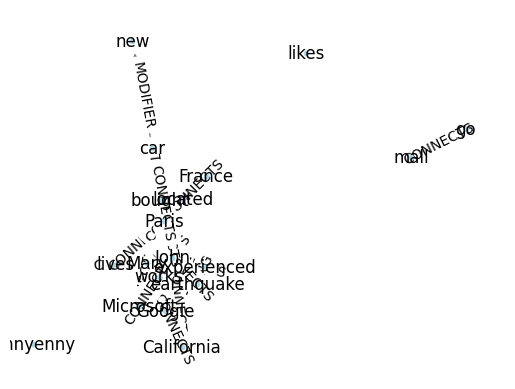

In [166]:
    

import json

with open('knowledge_graph.json', 'r') as file:
    graph_data = json.load(file)
    nodes = graph_data["nodes"]
    links = graph_data["links"]

    facts = {}

    for node in nodes:
        if node["label"] in ["THING", "ORG", "PERSON", "GPE"]:
            node_id = node["id"]

            connected_nodes = [
                link["target"] if link["source"] == node_id else link["source"]
                for link in links
                if link["source"] == node_id or link["target"] == node_id
            ]

            fact_info = [
                {"id": connected_node["id"], "label": connected_node["label"]}
                for connected_node in nodes
                if connected_node["id"] in connected_nodes
            ]

            facts[node_id] = fact_info

node_labels = {node["id"]: node["label"] for node in nodes}

for name in facts.keys():
    fact = facts[name]
    print(f"{name} ({node_labels[name]})")
    for f in fact:
        print(f'\t{f["id"]} ({f["label"]})')


John (PERSON)
	works (ACTION)
	Google (ORG)
	California (GPE)
	experienced (ACTION)
	earthquake (THING)
Google (ORG)
	works (ACTION)
	John (PERSON)
	California (GPE)
California (GPE)
	John (PERSON)
	Google (ORG)
Mary (PERSON)
	works (ACTION)
	lives (ACTION)
	Paris (GPE)
	Microsoft (ORG)
Paris (GPE)
	lives (ACTION)
	Mary (PERSON)
	located (ACTION)
	France (GPE)
Microsoft (ORG)
	works (ACTION)
	Mary (PERSON)
France (GPE)
	Paris (GPE)
	located (ACTION)
earthquake (THING)
	John (PERSON)
	experienced (ACTION)
Jennyenny (PERSON)
	is (AUX)
mall (THING)
	go (ACTION)


In [146]:
def print_facts_from_json_and_resolved_docs(json_file, sentences):
    with open(json_file, 'r') as file:
        graph_data = json.load(file)
        nodes = graph_data["nodes"]
        links = graph_data["links"]

    facts = {}

    for node in nodes:
        if node["label"] in ["THING", "ORG", "PERSON", "GPE"]:
            node_id = node["id"]

            connected_nodes = [
                link["target"] if link["source"] == node_id else link["source"]
                for link in links
                if link["source"] == node_id or link["target"] == node_id
            ]

            fact_info = [
                {"id": connected_node["id"], "label": connected_node["label"]}
                for connected_node in nodes
                if connected_node["id"] in connected_nodes
            ]

            facts[node_id] = fact_info

    node_labels = {node["id"]: node["label"] for node in nodes}

    for sentence in sentences:
        doc = nlp(sentence)
        for name, fact in facts.items():
            if name in sentence:
                print(f"{name} ({node_labels[name]})")
                for f in fact:
                    if f["id"] in sentence:
                        print(f'\t{f["id"]} ({f["label"]})')

    return facts

facts = print_facts_from_json_and_resolved_docs("knowledge_graph.json", sentences)
print(facts)

John (PERSON)
	works (ACTION)
	Google (ORG)
	California (GPE)
Google (ORG)
	works (ACTION)
	John (PERSON)
	California (GPE)
California (GPE)
	John (PERSON)
	Google (ORG)
Mary (PERSON)
	works (ACTION)
	lives (ACTION)
	Paris (GPE)
	Microsoft (ORG)
Paris (GPE)
	lives (ACTION)
	Mary (PERSON)
Microsoft (ORG)
	works (ACTION)
	Mary (PERSON)
Eiffel Tower (THING)
	located (ACTION)
	France (GPE)
France (GPE)
	located (ACTION)
	Eiffel Tower (THING)
Paris (GPE)
	located (ACTION)
	France (GPE)
France (GPE)
	Paris (GPE)
	located (ACTION)
{'John': [{'id': 'works', 'label': 'ACTION'}, {'id': 'Google', 'label': 'ORG'}, {'id': 'California', 'label': 'GPE'}], 'Google': [{'id': 'works', 'label': 'ACTION'}, {'id': 'John', 'label': 'PERSON'}, {'id': 'California', 'label': 'GPE'}], 'California': [{'id': 'John', 'label': 'PERSON'}, {'id': 'Google', 'label': 'ORG'}], 'Mary': [{'id': 'works', 'label': 'ACTION'}, {'id': 'lives', 'label': 'ACTION'}, {'id': 'Paris', 'label': 'GPE'}, {'id': 'Microsoft', 'label': 'O

In [163]:
import json

with open('knowledge_graph.json', 'r') as file:
    graph_data = json.load(file)
    nodes = graph_data["nodes"]
    links = graph_data["links"]

    facts = {}

    for node in nodes:
        if node["label"] in ["THING", "ORG", "PERSON", "GPE"]:
            node_id = node["id"]

            connected_nodes = [
                link["target"] if link["source"] == node_id else link["source"]
                for link in links
                if link["source"] == node_id or link["target"] == node_id
            ]

            fact_info = [
                {"id": connected_node["id"], "label": connected_node["label"]}
                for connected_node in nodes
                if connected_node["id"] in connected_nodes
            ]

            facts[node_id] = fact_info

    node_labels = {node["id"]: node["label"] for node in nodes}

    for node_id, fact_info in facts.items():
        subject = node_id
        subject_label = node_labels[node_id]

        for fact in fact_info:
            predicate = "works" if subject_label == "PERSON" and fact["label"] == "ORG" else "lives" if subject_label == "PERSON" and fact["label"] == "GPE" else "located" if subject_label == "GPE" and fact["label"] == "THING" else "works"

            object_ = fact["id"]
            object_label = fact["label"]

            sentence = f"{subject} ({subject_label}) {predicate} {object_} ({object_label})"
            print(sentence)

John (PERSON) works works (ACTION)
John (PERSON) works Google (ORG)
John (PERSON) lives California (GPE)
John (PERSON) works experienced (ACTION)
John (PERSON) works earthquake (THING)
Google (ORG) works works (ACTION)
Google (ORG) works John (PERSON)
Google (ORG) works California (GPE)
California (GPE) works John (PERSON)
California (GPE) works Google (ORG)
Mary (PERSON) works works (ACTION)
Mary (PERSON) works lives (ACTION)
Mary (PERSON) lives Paris (GPE)
Mary (PERSON) works Microsoft (ORG)
Paris (GPE) works lives (ACTION)
Paris (GPE) works Mary (PERSON)
Paris (GPE) works located (ACTION)
Paris (GPE) works France (GPE)
Microsoft (ORG) works works (ACTION)
Microsoft (ORG) works Mary (PERSON)
France (GPE) works Paris (GPE)
France (GPE) works located (ACTION)
earthquake (THING) works John (PERSON)
earthquake (THING) works experienced (ACTION)


In [ ]:
import csv
# CQL to create states as nodes
# CQL to query the difference in population from a given state to all the other states.
# Create relationships between the states as defined above (i.e. region and the binary classifications).
# Use the above states_df to read the data (i.e. please don't repeatedly write out state and/or field names).


# import the neo4j driver for Python
from neo4j import GraphDatabase
from scipy import stats
import pandas as pd
import numpy as np


# Save nodes as nodes.csv
with open('nodes.csv', 'w', newline='') as csvfile:
    fieldnames = ['id', 'label']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for node in graph_data['nodes']:
        writer.writerow(node)

# Save edges as edges.csv
with open('edges.csv', 'w', newline='') as csvfile:
    fieldnames = ['source', 'target', 'label']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for edge in graph_data['links']:
        writer.writerow(edge)



In [ ]:

# Database Credentials
uri = "bolt://192.168.3.224:7687"
user = "neo4j"
password = "senator-index-nebula-silver-zero-9434"

# Load the CSV files into a Neo4j database
from neo4j import GraphDatabase

driver = GraphDatabase.driver(uri, auth=(user, password))

def load_csv_to_neo4j(tx):
    # Create nodes from nodes.csv
    tx.run("""
    LOAD CSV WITH HEADERS FROM 'file:///nodes.csv' AS row
    MERGE (n:Node {id: row.id})
    SET n.label = row.label
    """)

    # Create edges from edges.csv
    tx.run("""
    LOAD CSV WITH HEADERS FROM 'file:///edges.csv' AS row
    MATCH (source:Node {id: row.source}), (target:Node {id: row.target})
    MERGE (source)-[r:CONNECTS]->(target)
    SET r.label = row.label
    """)

with driver.session() as session:
    session.write_transaction(load_csv_to_neo4j)

driver.close()